In [1]:
import sys 
sys.path.append("..")

In [33]:
import umap
import operator
from xgboost import XGBClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from ksvd import ApproximateKSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from comon import creatMas, plot_ssp, creat_win_sum_data
from plots_report import plot_metrics

In [3]:
files = ['CZ1.txt', 'CZ2.txt', 'CZ3.txt', 'CZ4.txt','CZ5.txt', 'CZ6.txt',
         'CZ7.txt','CZ8.txt','CZ9.txt','CZ10.txt', 'CZ11.txt','CZ12.txt']

CZ = []
for file in files:
    with open('IndianOcean/'+file, 'r') as f:
        line = f.readlines()
        cz=creatMas(line)
    CZ.append(cz)
    
with open('IndianOcean/zs.txt', 'r') as f:
    line = f.readlines()
    line.remove(line[33])
zs = [-int(a) for a in line]

In [28]:
def AEncoder(input_dim, latent_dim):

    inputs = Input(shape=(input_dim,))
    inp_layar1 = Dense(25, activation='softplus',kernel_initializer='he_normal')(inputs)
  #  inp_layar1 = Dropout(0.1)(inp_layar1)
    
    encoded = Dense(latent_dim, activation='softplus', kernel_initializer='he_normal')(inp_layar1)
    
    dec_lay = Dense(25,activation='linear', kernel_initializer='he_normal')(encoded)
  #  dec_lay = Dropout(0.1)(dec_lay)
    decoded = Dense(input_dim,activation='linear', kernel_initializer='he_normal')(dec_lay)
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [50]:
def researcher_pca(CLF,X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10,15]):
    scores = []
    for n in n_comp:
        dec = PCA(n_components=n)
        clf = CLF()
        pipe = Pipeline([('dec', dec), ('clf', clf)])
        pipe.fit(X_train, Y_train)
        predict = pipe.predict(X_test)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores



def researcher_ksvd(CLF, X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10,15]):
    scores = []
    for n in n_comp:
        ksvd = ApproximateKSVD(n_components=n, transform_n_nonzero_coefs=n//2)
        meantr = np.mean(X_train,axis=0)
        dictionary = ksvd.fit(X_train - meantr).components_
        gamma_train = ksvd.transform(X_train - meantr)
        gamma_test = ksvd.transform(X_test - meantr)
        
        clf = CLF()
        clf.fit(gamma_train, Y_train)
        predict = clf.predict(gamma_test)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores


def researcher_ae(CLF, X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10,15]):
    scores = []
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    for n in n_comp:
        autoencoder_std, encoder_std = AEncoder(33, n)
        autoencoder_std.fit(X_train_std, X_train_std,
                epochs=450,
                batch_size=64,
                shuffle=True, verbose=0)
          
        test_embedding = encoder_std.predict(X_test_std)
        train_embedding = encoder_std.predict(X_train_std)
        
        clf = CLF()
        clf.fit(train_embedding, Y_train)
        predict = clf.predict(test_embedding)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores

In [48]:
def plot_confusion_matrix(cm, classes=['winter', 'summer'],
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_metrics(clf, X_train, X_test, y_train, y_test):
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)
    print('Accuracy на тренировочных данных: {}'.format(accuracy_score(y_train, predict_train)))
    print('Accuracy на тестовых данных: {}'.format(accuracy_score(y_test, predict_test)))
    
    plot_confusion_matrix(confusion_matrix(y_train, predict_train), title='Confusion matrix для обучающих данных')
    plot_confusion_matrix(confusion_matrix(y_test, predict_test), title='Confusion matrix для тестовых данных')
    
def feature_importances(clf, size = (10,12), title_x = 'Важность координаты', title_y = 'Глубина', zs = zs):
    fi = clf.feature_importances_
    x = range(1,len(fi)+1)
    plt.figure(figsize=size)
    plt.barh(x, fi)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.yticks(x,list(map(str,zs)))
    plt.show()

In [8]:
winter_index, summer_index = [12, 1, 2], [6, 7, 8]
X, Y = creat_win_sum_data(CZ, winter_index, summer_index)
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=0)

In [70]:
len(X_test)

840

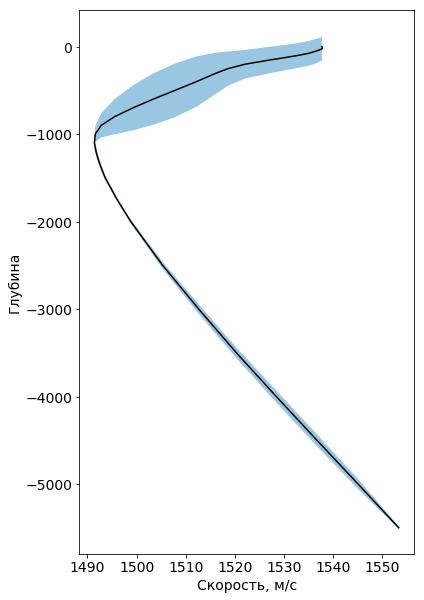

In [73]:
x  = np.array(X_train)
x_std = np.std(x, axis=0)
x_mean = np.mean(x, axis=0)
plt.figure(figsize=(6,10))
plt.plot(x_mean,zs, 'k')
plt.ylabel('Глубина')
plt.xlabel('Скорость, м/с')
plt.fill_between(x_mean, zs - 30*x_std, zs + 30*x_std, alpha=0.4)
plt.show()

## LogisticRegression

In [10]:
clf = LogisticRegression()
param = [0.01, 0.1, 1, 10, 20, 30, 50, 70, 100, 120, 130]
param_grid = { 'C': param }

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'C': 20}

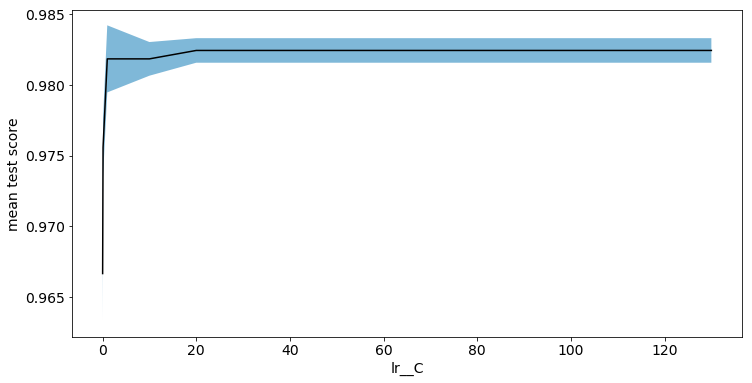

In [11]:
mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score/2, mean_scor + std_score/2, alpha=0.5)
plt.xlabel('lr__C')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 0.9857142857142858
Accuracy на тестовых данных: 0.9761904761904762


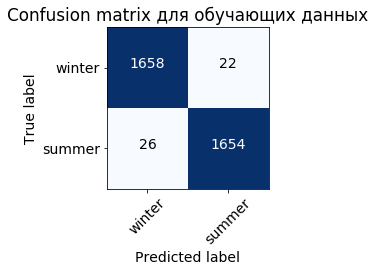

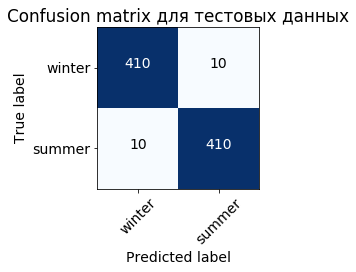

In [13]:
clf = LogisticRegression(C=20)
clf.fit(X_train, y_train)
print_metrics(clf, X_train, X_test, y_train, y_test)

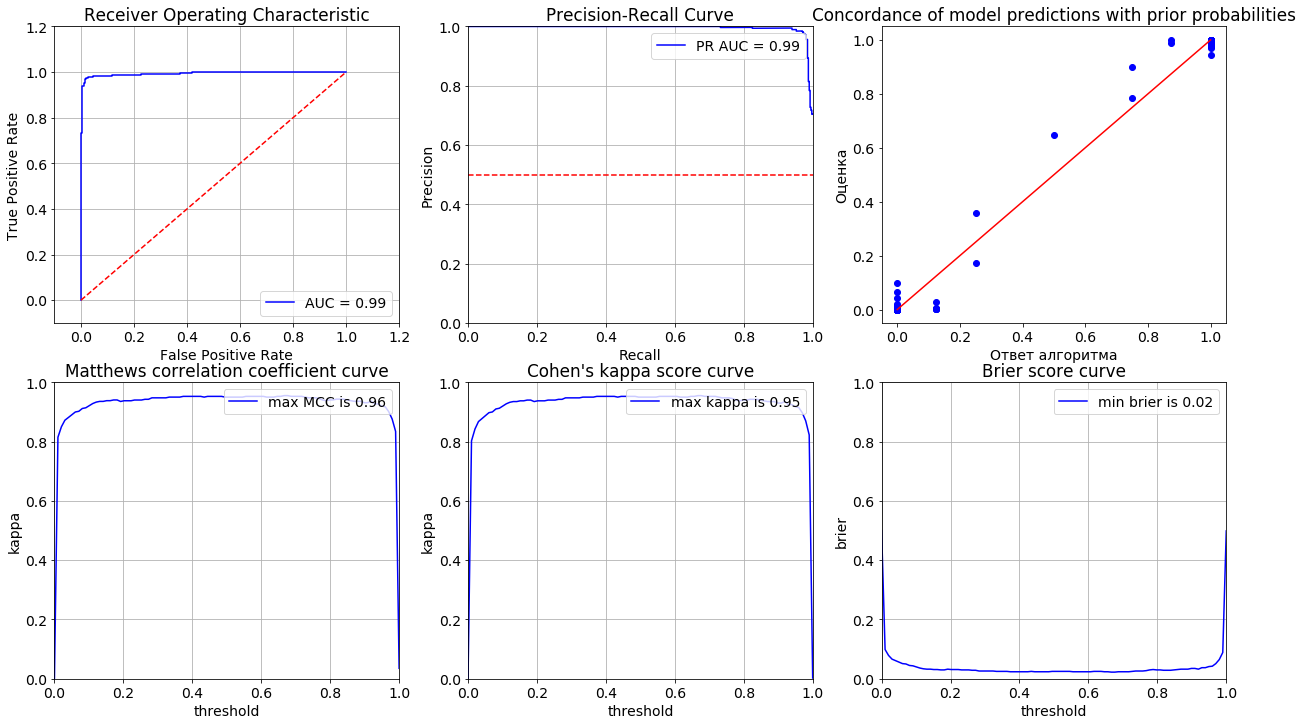

The rmse of model's prediction is: 0.1423
The Gini of model's prediction is: 0.9877
The ROC AUC of model's prediction is: 0.9939
The PR AUC of model's prediction is: 0.9948
Max Cohen's kappa is 0.955 with threshold = 0.67
Max Matthews correlation coefficient is 0.955 with threshold = 0.67
Min Brier score is 0.022 with threshold = 0.67


In [14]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

**Важность координат**

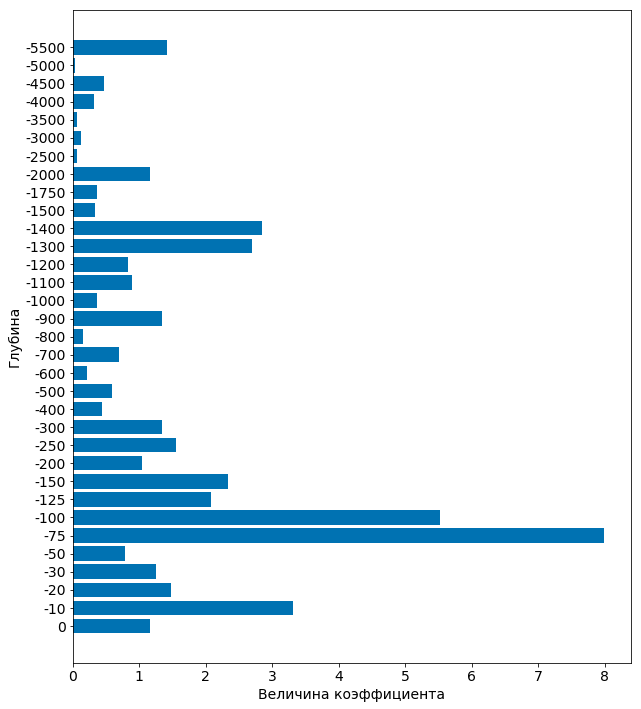

In [15]:
x = range(1,34)
y = list(map(abs,clf.coef_[0]))
plt.figure(figsize=(10,12))
plt.barh(x, y)
plt.xlabel('Величина коэффициента')
plt.ylabel('Глубина')
plt.yticks(x,list(map(str,zs)))
plt.show()

## LogisticRegression + StandardScaler

In [16]:
std = StandardScaler()
clf = LogisticRegression()
pipe = Pipeline([('std', std), ('lg', clf)])

In [17]:
param = [0.01, 0.1, 1, 10, 20, 30, 50, 70, 100, 120, 130]
param_grid = { 'lg__C': param }
grd = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'lg__C': 100}

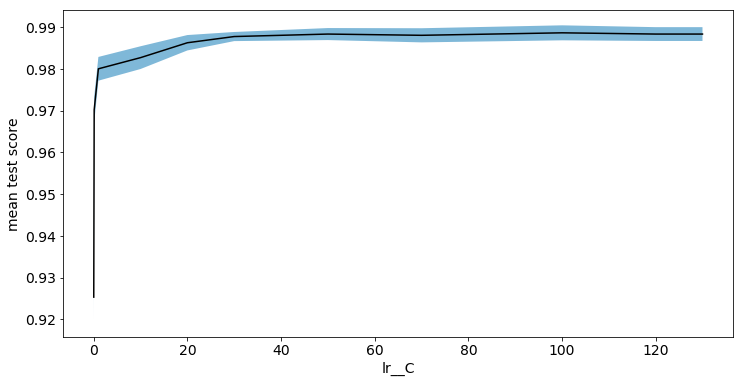

In [18]:
mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score/2, mean_scor + std_score/2, alpha=0.5)
plt.xlabel('lr__C')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 0.9889880952380953
Accuracy на тестовых данных: 0.9857142857142858


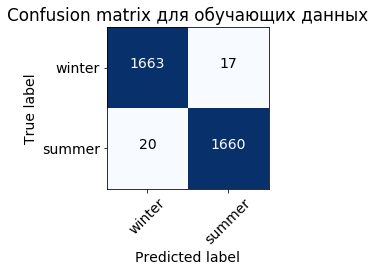

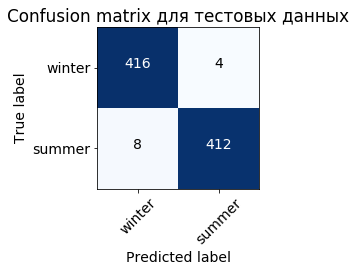

In [19]:
std = StandardScaler()
clf = LogisticRegression(C=30)
pipe = Pipeline([('std', std), ('lg', clf)])

pipe.fit(X_train, y_train)
print_metrics(pipe, X_train, X_test, y_train, y_test)

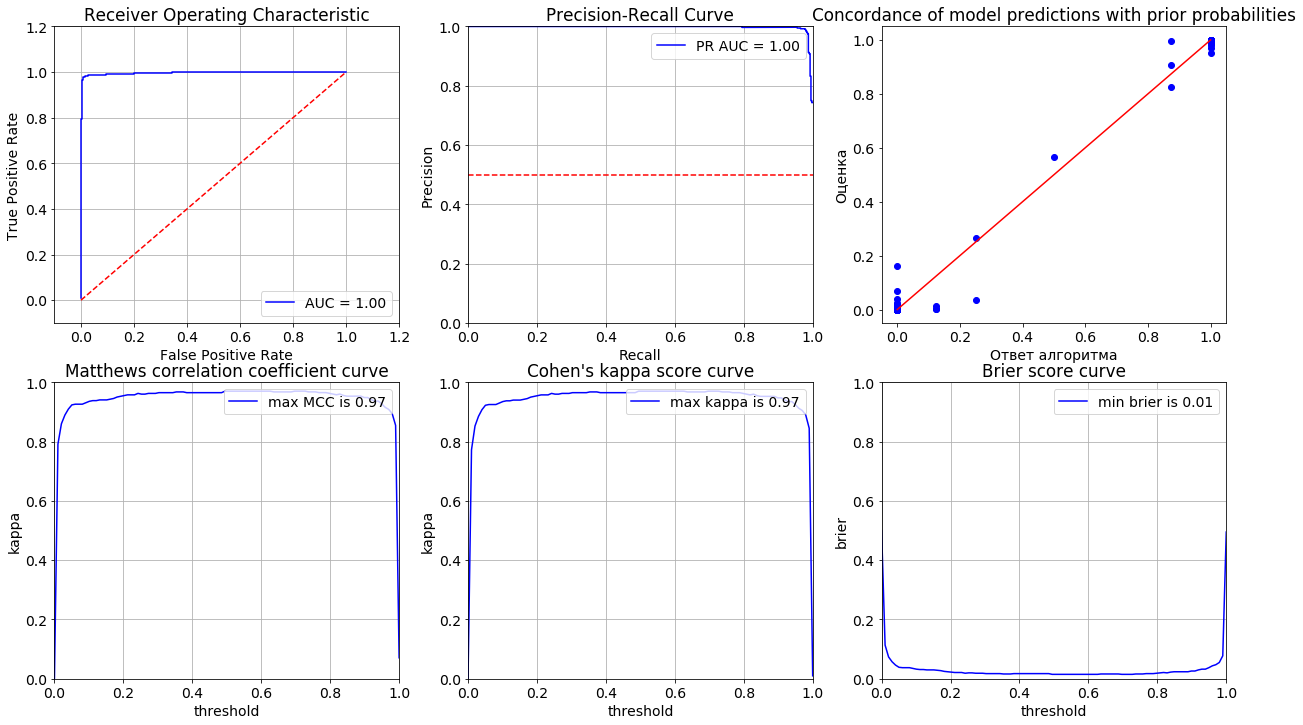

The rmse of model's prediction is: 0.1176
The Gini of model's prediction is: 0.9932
The ROC AUC of model's prediction is: 0.9966
The PR AUC of model's prediction is: 0.9971
Max Cohen's kappa is 0.970 with threshold = 0.49
Max Matthews correlation coefficient is 0.970 with threshold = 0.70
Min Brier score is 0.015 with threshold = 0.49


In [20]:
pr_prob = pipe.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

## LogisticRegression + PCA

**Зависимость точности классификации от числа компонент**

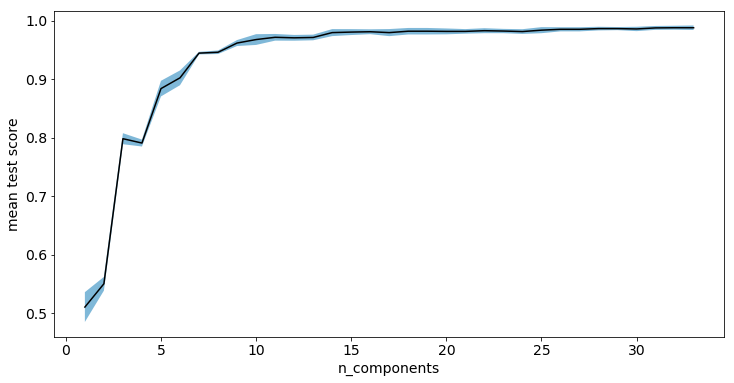

In [21]:
pca = PCA()
clf = LogisticRegression(C=1)
pipe = Pipeline([('pca', pca), ('lg', clf)])

param = list(range(1,34))
param_grid = { 'pca__n_components': param }

grd = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)

grd.fit(X_train, y_train)

mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score, mean_scor + std_score, alpha=0.5)
plt.xlabel('n_components')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 0.9693452380952381
Accuracy на тестовых данных: 0.969047619047619


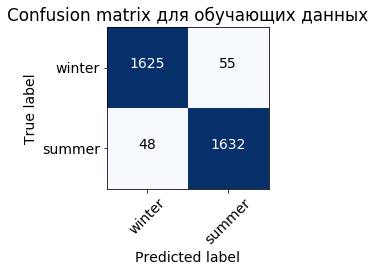

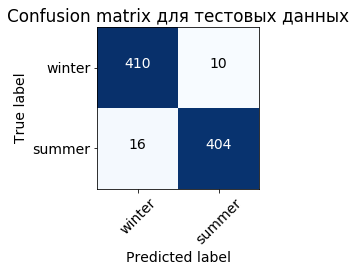

In [22]:
pca = PCA(n_components=10)
clf = LogisticRegression()
pipe = Pipeline([('pca', pca), ('lg', clf)])
pipe.fit(X_train, y_train)
print_metrics(pipe, X_train, X_test, y_train, y_test)

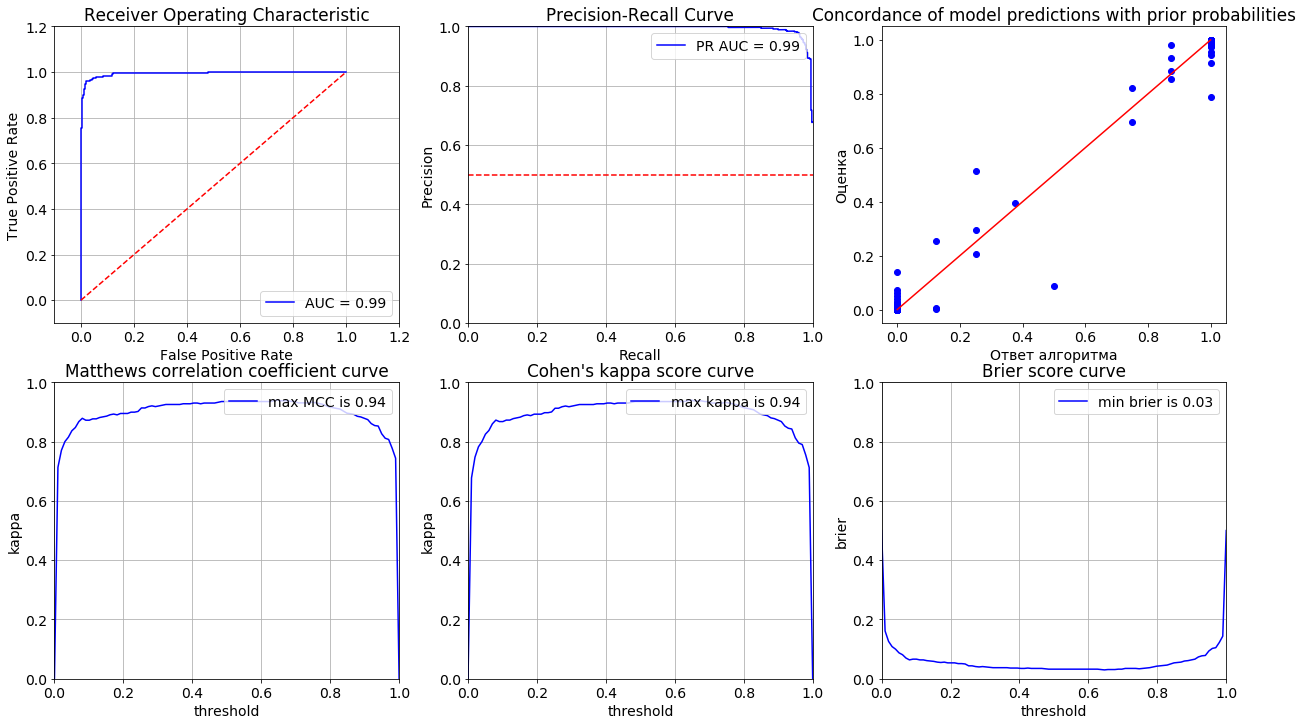

The rmse of model's prediction is: 0.1621
The Gini of model's prediction is: 0.9879
The ROC AUC of model's prediction is: 0.9939
The PR AUC of model's prediction is: 0.9946
Max Cohen's kappa is 0.940 with threshold = 0.65
Max Matthews correlation coefficient is 0.940 with threshold = 0.65
Min Brier score is 0.030 with threshold = 0.65


In [23]:
pr_prob = pipe.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

In [36]:
researcher_pca(LogisticRegression, X_train, y_train, X_test, y_test)

[0.80000000000000004,
 0.90714285714285714,
 0.94761904761904758,
 0.96904761904761905,
 0.97857142857142854]

In [26]:
researcher_ksvd(LogisticRegression, X_train, y_train, X_test, y_test)

[0.72976190476190472,
 0.74761904761904763,
 0.87023809523809526,
 0.95357142857142863,
 0.96785714285714286]

In [51]:
researcher_ae(LogisticRegression, X_train, y_train, X_test, y_test)

[0.57857142857142863,
 0.83214285714285718,
 0.8392857142857143,
 0.90833333333333333,
 0.96904761904761905]

## RandomForestClassifier

In [52]:
clf = RandomForestClassifier()
param_grid = { 'n_estimators': [1, 5, 10, 20, 50, 75, 100, 150, 200, 300, 400, 500], 'min_samples_split' : [2, 3, 4] }

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'min_samples_split': 3, 'n_estimators': 300}

In [53]:
clf = RandomForestClassifier(min_samples_split=2, n_estimators=150)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9928571428571429


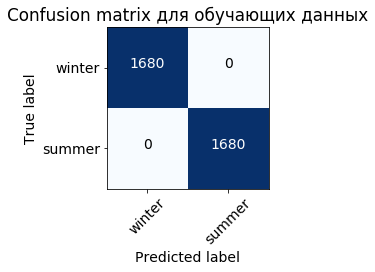

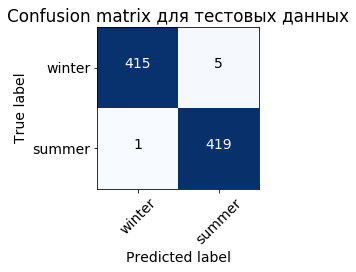

In [54]:
print_metrics(clf, X_train, X_test, y_train, y_test)

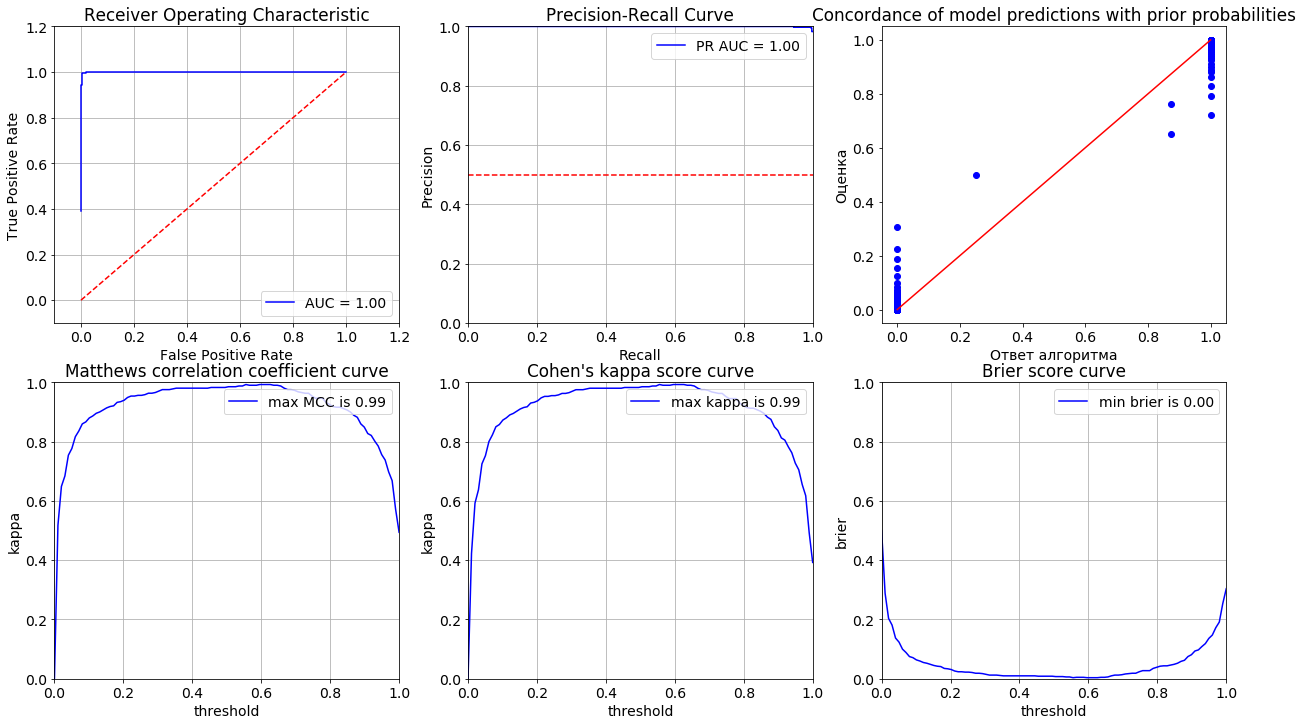

The rmse of model's prediction is: 0.1016
The Gini of model's prediction is: 0.9996
The ROC AUC of model's prediction is: 0.9998
The PR AUC of model's prediction is: 0.9998
Max Cohen's kappa is 0.993 with threshold = 0.56
Max Matthews correlation coefficient is 0.993 with threshold = 0.56
Min Brier score is 0.004 with threshold = 0.56


In [55]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

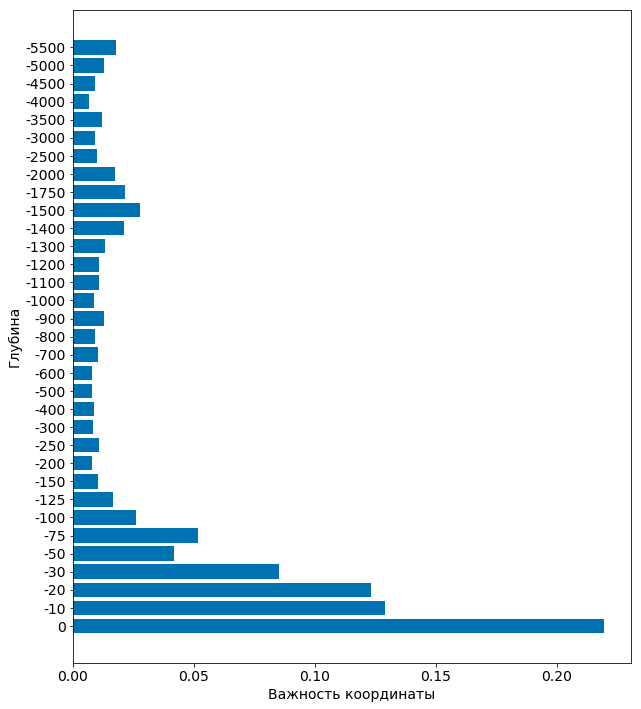

In [56]:
feature_importances(clf)

In [57]:
researcher_pca(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.90238095238095239,
 0.96071428571428574,
 0.97738095238095235,
 0.97976190476190472,
 0.99047619047619051]

In [87]:
researcher_ksvd(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.6785714285714286,
 0.8273809523809523,
 0.930952380952381,
 0.9666666666666667,
 0.9797619047619047]

In [60]:
researcher_ae(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.75595238095238093,
 0.93095238095238098,
 0.94880952380952377,
 0.96309523809523812,
 0.98095238095238091]

## Бустинг

In [36]:
n_est = [100, 200, 500,700, 1000]
max_dep = [1,2,3]
lr = [0.01, 0.1, 0.5, 1]
clf = XGBClassifier()
param_grid = { 'n_estimators': n_est, 'max_depth':max_dep, 'learning_rate':lr}

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(np.array(X_train), y_train)
grd.best_params_

{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 700}

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9988095238095238


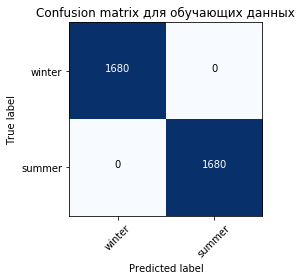

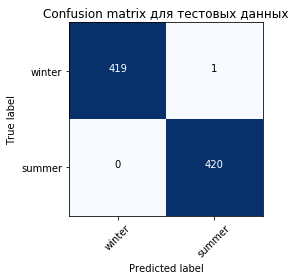

In [88]:
clf = XGBClassifier(n_estimators=700, learning_rate=0.5, max_depth=2)
clf.fit(np.array(X_train), y_train)
print_metrics(clf, X_train, X_test, y_train, y_test)

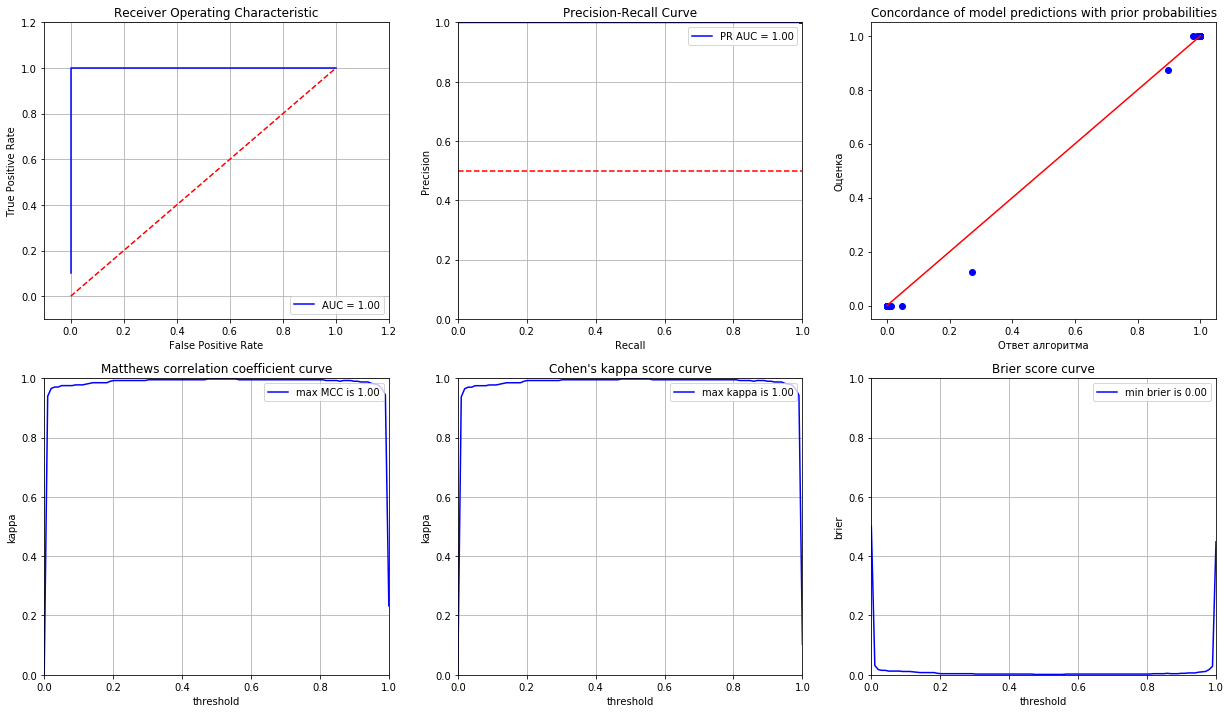

The rmse of model's prediction is: 0.0434
The Gini of model's prediction is: 1.0000
The ROC AUC of model's prediction is: 1.0000
The PR AUC of model's prediction is: 1.0000
Max Cohen's kappa is 0.998 with threshold = 0.47
Max Matthews correlation coefficient is 0.998 with threshold = 0.47
Min Brier score is 0.001 with threshold = 0.47


In [89]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

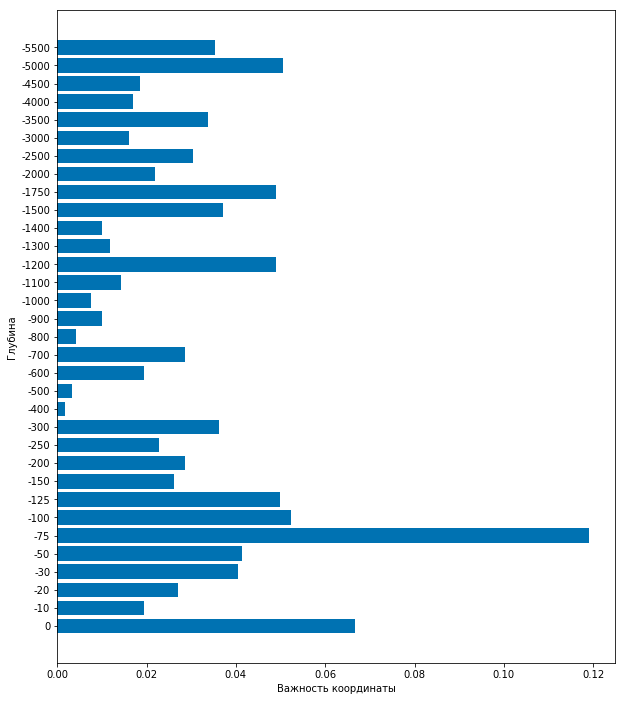

In [90]:
feature_importances(clf)

In [91]:
researcher_pca(XGBClassifier, X_train, y_train, X_test, y_test)

[0.8869047619047619,
 0.9511904761904761,
 0.975,
 0.9785714285714285,
 0.9809523809523809]

In [92]:
researcher_ksvd(XGBClassifier, X_train, y_train, X_test, y_test)

[0.6142857142857143,
 0.8130952380952381,
 0.8809523809523809,
 0.9583333333333334,
 0.9702380952380952]

In [61]:
researcher_ae(XGBClassifier, X_train, y_train, X_test, y_test)

[0.70952380952380956,
 0.92023809523809519,
 0.92380952380952386,
 0.96309523809523812,
 0.97261904761904761]

## Важность главных компонент

In [104]:
pca = PCA(n_components=15)
pca.fit(X_train)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)


ksvd = ApproximateKSVD(n_components=15, transform_n_nonzero_coefs=7)
meantr = np.mean(X_train,axis=0)
dictionary = ksvd.fit(X_train - meantr).components_
gamma_train = ksvd.transform(X_train - meantr)

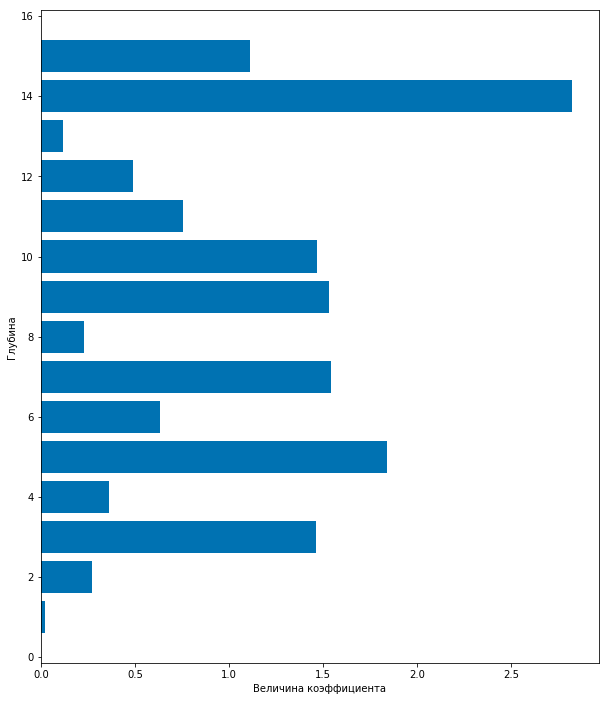

In [113]:
clf = LogisticRegression().fit(X_pca_train, y_train)
x = range(1,16)
y = list(map(abs,clf.coef_[0]))
plt.figure(figsize=(10,12))
plt.barh(x, y)
plt.xlabel('Величина коэффициента')
plt.ylabel('Глубина')
#plt.yticks(x,list(map(str,zs)))
plt.show()

## Визуализация зима/лето

In [89]:
win_data = [X[i] for i in range(len(X)) if Y[i] == 0]
sum_data = [X[i] for i in range(len(X)) if Y[i] == 1]

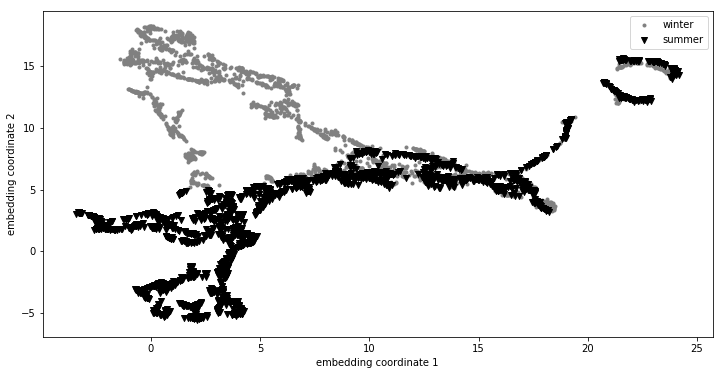

In [97]:
embedding = umap.UMAP()
embedding.fit(X)
win_emb = embedding.transform(win_data)
sum_emb = embedding.transform(sum_data)
plt.figure(figsize=(12,6))
plt.scatter(win_emb[:,0], win_emb[:,1], c = 'grey', label='winter', marker = ".")
plt.scatter(sum_emb[:,0], sum_emb[:,1], c = 'black', label = 'summer',marker =  "v")
plt.xlabel('embedding coordinate 1')
plt.ylabel('embedding coordinate 2')
plt.legend()
plt.show()

## Визуализация по месяцам

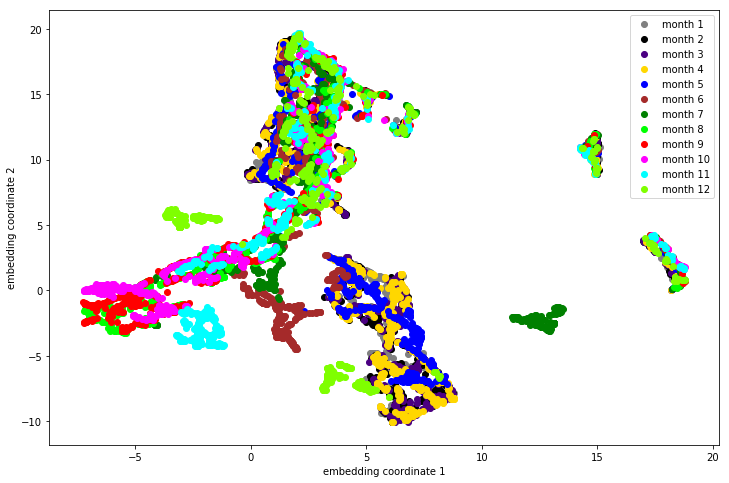

In [8]:
AllX = []
for x in CZ:
    AllX += list(x)
embedding.fit(AllX)

plt.figure(figsize=(12,8))
color = ['grey', 'black', 'indigo', 'gold', 'blue', 'brown', 'green', 'lime', 'red', 'fuchsia', 'cyan', 'chartreuse']
for i in range(12):
    x_emb = embedding.transform(CZ[i])
    plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
plt.legend()
plt.xlabel('embedding coordinate 1')
plt.ylabel('embedding coordinate 2')
plt.show()

**визуальная разделимость от колличества  компонент PCA**

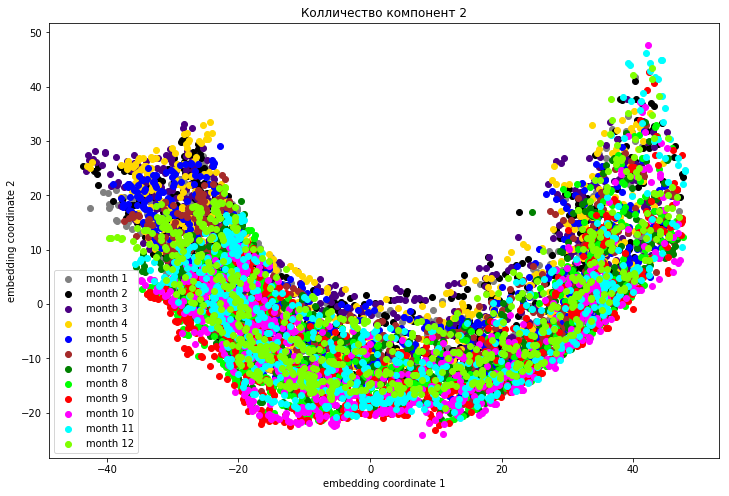

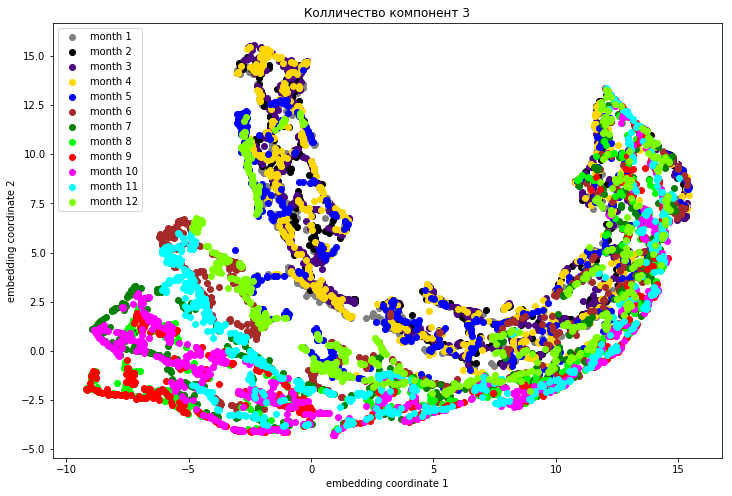

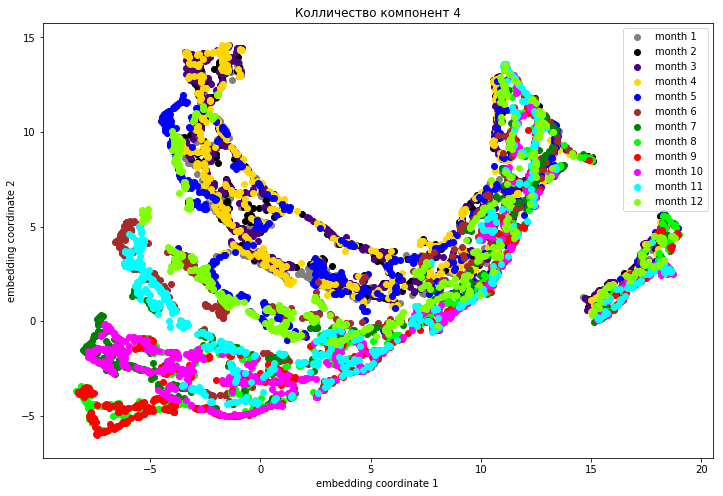

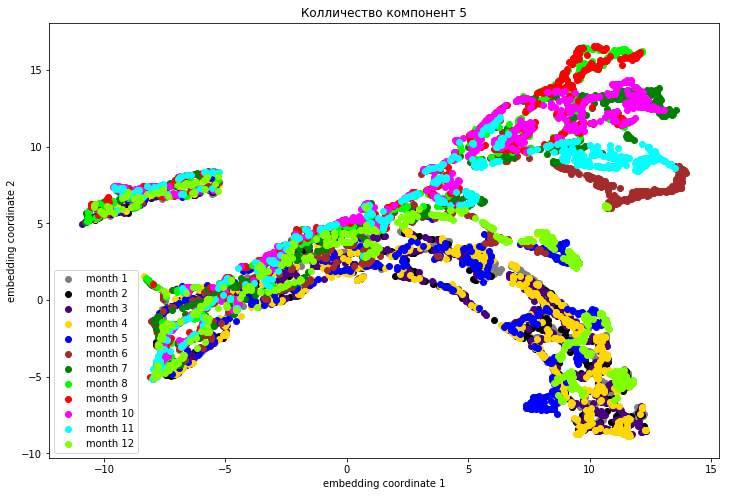

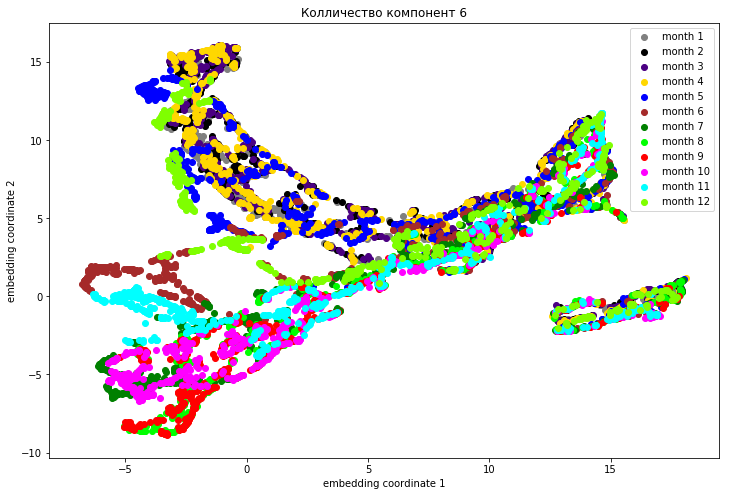

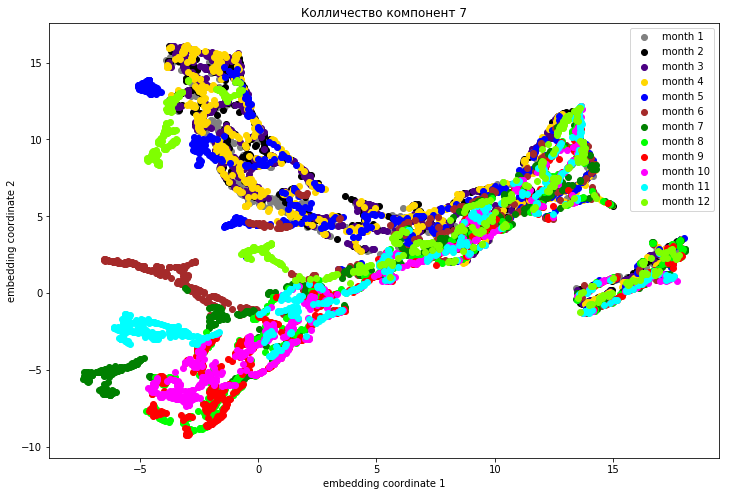

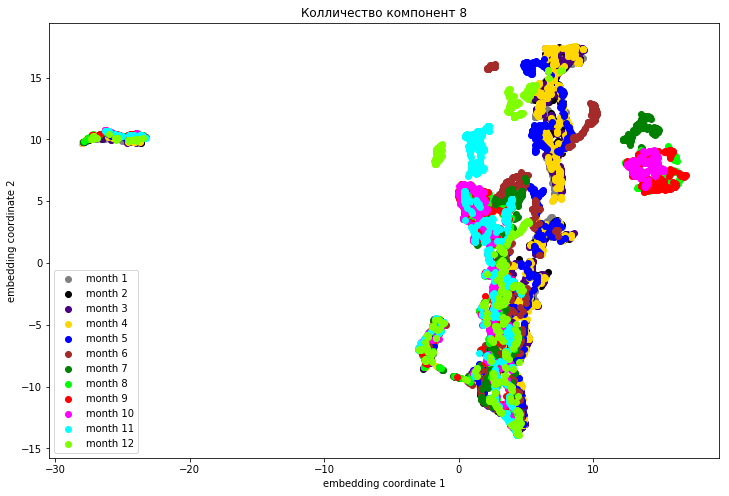

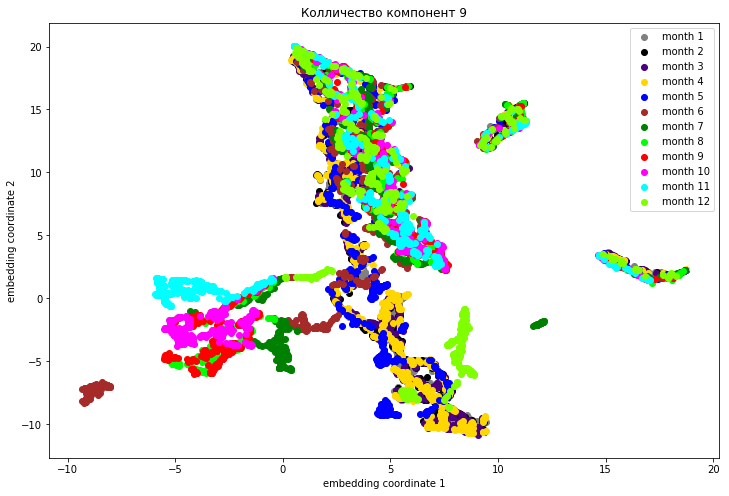

In [18]:
embedding = umap.UMAP()
for n_comp in range(2,10):
    pca = PCA(n_components=n_comp)
    AllX_red = pca.fit_transform(AllX)
    embedding.fit(AllX_red)
    plt.figure(figsize=(12,8))
    for i in range(12):
        if n_comp == 2: x_emb = pca.transform(CZ[i])
        else: x_emb = embedding.transform(pca.transform(CZ[i]))
        plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
        plt.title("Колличество компонент {}".format(n_comp))
        plt.legend()
    plt.xlabel('embedding coordinate 1')
    plt.ylabel('embedding coordinate 2')
    plt.show()